In [ ]:
import pandas as pd
import numpy as np
import re
import random
from datetime import datetime, timedelta

#  Define our own data for generation 
VENDORS = [
    "Innovate Corp", "Quantum Solutions", "Data Systems Ltd", "Future Tech",
    "Global Logistics", "Starlight Services", "Apex Digital", "Summit Industries"
]
ITEMS = [
    "Software License", "Consulting Hours", "Cloud Storage (GB)", "Hardware Unit",
    "Support Contract", "Data Analysis Report", "Network Device", "Security Audit"
]


def create_invoice_text(is_anomaly=False, used_invoice_nos=None):
    """Generates a string of text representing a synthetic invoice without Faker."""
    if used_invoice_nos is None:
        used_invoice_nos = set()

    # 1. Vendor and Date (using our own lists and datetime)
    vendor_name = random.choice(VENDORS)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)
    random_days = random.randint(0, (end_date - start_date).days)
    invoice_date = start_date + timedelta(days=random_days)
    
    # 2. Invoice Number
    if is_anomaly and random.random() > 0.5 and used_invoice_nos:
        # Create a duplicate invoice number for an anomaly
        invoice_no = random.choice(list(used_invoice_nos))
    else:
        invoice_no = f"INV-{random.randint(1000, 99999)}"
        used_invoice_nos.add(invoice_no)

    # 3. Line Items
    items_text = ""
    actual_total = 0.0
    for _ in range(random.randint(2, 5)):
        item = random.choice(ITEMS)
        quantity = random.randint(1, 10)
        price = round(random.uniform(10.0, 500.0), 2)
        line_total = quantity * price
        items_text += f"- {item}: {quantity} x ${price:.2f} = ${line_total:.2f}\n"
        actual_total += line_total
    
    # 4. Total Amount
    if is_anomaly:
        # Create a mismatched total for an anomaly
        displayed_total = actual_total + round(random.uniform(50, 500), 2)
    else:
        displayed_total = actual_total

    # 5. Assemble the invoice text
    invoice_template = f"""
    INVOICE
    From: {vendor_name}
    Date: {invoice_date.strftime('%Y-%m-%d')}
    Invoice #: {invoice_no}

    ---
    Items:
    {items_text}
    ---
    Total: ${displayed_total:.2f}
    """
    return invoice_template, invoice_no, actual_total

#  Generate the dataset 
print("Generating synthetic invoice data")
invoices = []
used_invoice_nos_global = set()

# Generate 270 normal invoices
for _ in range(270):
    text, inv_no, actual_total = create_invoice_text(is_anomaly=False, used_invoice_nos=used_invoice_nos_global)
    invoices.append({'text': text, 'actual_total': actual_total, 'is_anomaly': 0})

# Generate 30 anomalous invoices
for _ in range(30):
    text, inv_no, actual_total = create_invoice_text(is_anomaly=True, used_invoice_nos=used_invoice_nos_global)
    invoices.append({'text': text, 'actual_total': actual_total, 'is_anomaly': 1})

# Shuffle the dataset
random.shuffle(invoices)
df_invoices = pd.DataFrame(invoices)

print(f"Successfully generated {len(df_invoices)} invoices.")
print("An example of a generated invoice:")
print("---------------------------------")
print(df_invoices['text'].iloc[0])

Generating synthetic invoice data...
Successfully generated 300 invoices.
An example of a generated invoice:
---------------------------------

    INVOICE
    From: Summit Industries
    Date: 2024-11-10
    Invoice #: INV-77262

    ---
    Items:
    - Software License: 6 x $57.55 = $345.30
- Software License: 5 x $232.67 = $1163.35
- Data Analysis Report: 4 x $360.37 = $1441.48
- Data Analysis Report: 9 x $274.09 = $2466.81
- Network Device: 8 x $468.10 = $3744.80

    ---
    Total: $9427.97
    


In [ ]:
def extract_invoice_data(invoice_text):
    """Parses text to extract key invoice fields using regex."""
    vendor_match = re.search(r"From:\s*(.*)", invoice_text)
    date_match = re.search(r"Date:\s*(\d{4}-\d{2}-\d{2})", invoice_text)
    invoice_no_match = re.search(r"Invoice #:\s*(INV-\d+)", invoice_text)
    total_match = re.search(r"Total:\s*\$([\d.]+)", invoice_text)
    
    line_item_totals = re.findall(r"=\s*\$([\d.]+)", invoice_text)
    calculated_total = sum(float(total) for total in line_item_totals)

    data = {
        'vendor': vendor_match.group(1).strip() if vendor_match else None,
        'date': date_match.group(1).strip() if date_match else None,
        'invoice_no': invoice_no_match.group(1).strip() if invoice_no_match else None,
        'displayed_total': float(total_match.group(1)) if total_match else 0.0,
        'calculated_total': round(calculated_total, 2)
    }
    return data

# Apply the extraction function to our dataset 
print("\nExtracting information from all invoices")
extracted_data = df_invoices['text'].apply(extract_invoice_data)
df_extracted = pd.json_normalize(extracted_data)

# Combine with the original dataframe
df_final = pd.concat([df_invoices.reset_index(drop=True), df_extracted], axis=1)
print("Extraction complete. Here's a preview:")
print(df_final.head())


Extracting information from all invoices...
Extraction complete. Here's a preview:
                                                text  actual_total  \
0  \n    INVOICE\n    From: Summit Industries\n  ...       9161.74   
1  \n    INVOICE\n    From: Starlight Services\n ...       2415.83   
2  \n    INVOICE\n    From: Summit Industries\n  ...       5476.40   
3  \n    INVOICE\n    From: Future Tech\n    Date...       2535.89   
4  \n    INVOICE\n    From: Summit Industries\n  ...       3319.30   

   is_anomaly              vendor        date invoice_no  displayed_total  \
0           1   Summit Industries  2024-11-10  INV-77262          9427.97   
1           0  Starlight Services  2024-10-01  INV-63676          2415.83   
2           0   Summit Industries  2025-08-07  INV-91923          5476.40   
3           0         Future Tech  2025-05-20  INV-42515          2535.89   
4           0   Summit Industries  2024-09-29   INV-1340          3319.30   

   calculated_total  
0         

In [17]:
print("\nEngineering features for the ML model...")

# 1. Total mismatch check
df_final['total_mismatch'] = (df_final['displayed_total'] != df_final['calculated_total']).astype(int)

# 2. Duplicate invoice number check
df_final['is_duplicate'] = df_final['invoice_no'].duplicated(keep=False).astype(int)

# 3. High amount check
amount_threshold = df_final['displayed_total'].quantile(0.95)
df_final['is_high_amount'] = (df_final['displayed_total'] > amount_threshold).astype(int)

print("Features created: 'total_mismatch', 'is_duplicate', 'is_high_amount'")
print("Preview of the data with features:")
print(df_final[['invoice_no', 'total_mismatch', 'is_duplicate', 'is_anomaly']].head())


Engineering features for the ML model...
Features created: 'total_mismatch', 'is_duplicate', 'is_high_amount'
Preview of the data with features:
  invoice_no  total_mismatch  is_duplicate  is_anomaly
0  INV-77262               1             0           1
1  INV-63676               0             0           0
2  INV-91923               0             0           0
3  INV-42515               0             0           0
4   INV-1340               0             0           0


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\nTraining the Random Forest model for anomaly detection...")

# Define features (X) and target (y)
features = ['total_mismatch', 'is_duplicate', 'is_high_amount', 'displayed_total']
target = 'is_anomaly'

X = df_final[features]
y = df_final[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

print("Model training complete.")


Training the Random Forest model for anomaly detection...
Model training complete.



Evaluating model performance and generating reports...
Model Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        81
     Anomaly       1.00      1.00      1.00         9

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90


--- Anomaly Detection Report ---
Found 9 potential anomalies in the test set:

Invoice #: INV-77262
  - Reason(s):
    - Total Mismatch (Displayed: $9427.97, Calculated: $9161.74)

Invoice #: INV-12083
  - Reason(s):
    - Total Mismatch (Displayed: $5959.85, Calculated: $5720.84)
    - Duplicate Invoice Number

Invoice #: INV-55821
  - Reason(s):
    - Total Mismatch (Displayed: $2570.13, Calculated: $2482.52)
    - Duplicate Invoice Number

Invoice #: INV-6227
  - Reason(s):
    - Total Mismatch (Displayed: $10365.75, Calculated: $10216.94)
    - Duplicate Invo

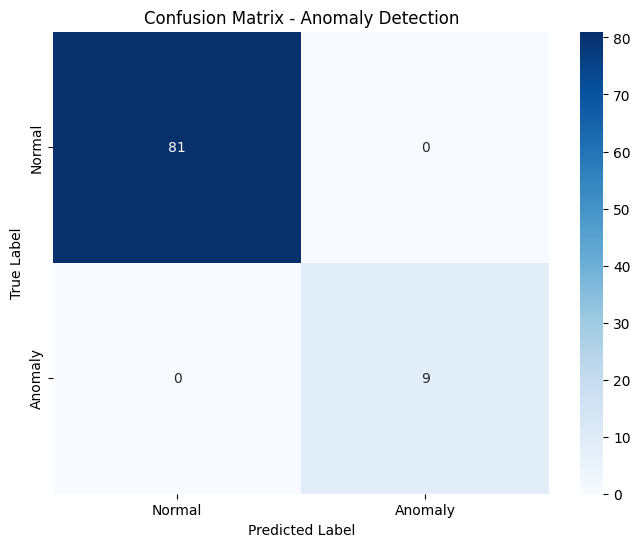

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\nEvaluating model performance and generating reports...")

# Make predictions
y_pred = model.predict(X_test)

# Evaluation Metrics 
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

#  Generate Report of Detected Anomalies 
test_indices = X_test.index
report_df = df_final.loc[test_indices].copy()
report_df['predicted_status'] = y_pred
anomalies_detected = report_df[report_df['predicted_status'] == 1]

print("\n Anomaly Detection Report ")
if not anomalies_detected.empty:
    print(f"Found {len(anomalies_detected)} potential anomalies in the test set:")
    for index, row in anomalies_detected.iterrows():
        print(f"\nInvoice #: {row['invoice_no']}")
        print(f"  - Reason(s):")
        if row['total_mismatch'] == 1:
            print(f"    - Total Mismatch (Displayed: ${row['displayed_total']:.2f}, Calculated: ${row['calculated_total']:.2f})")
        if row['is_duplicate'] == 1:
            print(f"    - Duplicate Invoice Number")
        if row['is_high_amount'] == 1:
            print(f"    - Unusually High Amount")
else:
    print("No anomalies were detected in the test set.")
print("End of Report ")

#Visual Output (Confusion Matrix) 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - Anomaly Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
import pandas as pd
import numpy as np
import re
import random
from datetime import datetime, timedelta

# (Use the same data lists and extraction function from the previous answer)
VENDORS = [
    "Innovate Corp", "Quantum Solutions", "Data Systems Ltd", "Future Tech",
    "Global Logistics", "Starlight Services", "Apex Digital", "Summit Industries"
]
ITEMS = [
    "Software License", "Consulting Hours", "Cloud Storage (GB)", "Hardware Unit",
    "Support Contract", "Data Analysis Report", "Network Device", "Security Audit"
]

def create_invoice_with_ground_truth(is_anomaly=False, used_invoice_nos=None):
    """
    MODIFIED data generation function.
    Now returns the text AND a dictionary of the true values.
    """
    # ... (The internal logic of this function is the same as before)
    if used_invoice_nos is None: used_invoice_nos = set()
    vendor_name = random.choice(VENDORS)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)
    random_days = random.randint(0, (end_date - start_date).days)
    invoice_date = start_date + timedelta(days=random_days)
    
    if is_anomaly and random.random() > 0.5 and used_invoice_nos:
        invoice_no = random.choice(list(used_invoice_nos))
    else:
        invoice_no = f"INV-{random.randint(1000, 99999)}"
        used_invoice_nos.add(invoice_no)

    items_text = ""
    actual_total = 0.0
    for _ in range(random.randint(2, 5)):
        item = random.choice(ITEMS)
        quantity = random.randint(1, 10)
        price = round(random.uniform(10.0, 500.0), 2)
        line_total = quantity * price
        items_text += f"- {item}: {quantity} x ${price:.2f} = ${line_total:.2f}\n"
        actual_total += line_total
    
    displayed_total = actual_total + round(random.uniform(50, 500), 2) if is_anomaly else actual_total
    
    invoice_template = f"""
    INVOICE
    From: {vendor_name}
    Date: {invoice_date.strftime('%Y-%m-%d')}
    Invoice #: {invoice_no}

    ---
    Items:
    {items_text}
    ---
    Total: ${displayed_total:.2f}
    """
    
    ground_truth = {
        'true_vendor': vendor_name,
        'true_date': invoice_date.strftime('%Y-%m-%d'),
        'true_invoice_no': invoice_no,
        'true_total': displayed_total
    }
    
    return invoice_template, ground_truth

# --- 1. Generate Data with Ground Truth ---
all_invoices = []
for i in range(300):
    is_anomaly_flag = i >= 270
    text, truth = create_invoice_with_ground_truth(is_anomaly=is_anomaly_flag)
    invoice_info = {
        'text': text,
        'is_anomaly': 1 if is_anomaly_flag else 0,
        **truth # Unpack the ground truth dictionary
    }
    all_invoices.append(invoice_info)

df = pd.DataFrame(all_invoices)

# --- 2. Extract Data (using the same function as before) ---
def extract_invoice_data(invoice_text):
    # This function is unchanged
    vendor_match = re.search(r"From:\s*(.*)", invoice_text)
    date_match = re.search(r"Date:\s*(\d{4}-\d{2}-\d{2})", invoice_text)
    invoice_no_match = re.search(r"Invoice #:\s*(INV-\d+)", invoice_text)
    total_match = re.search(r"Total:\s*\$([\d.]+)", invoice_text)
    data = {
        'pred_vendor': vendor_match.group(1).strip() if vendor_match else None,
        'pred_date': date_match.group(1).strip() if date_match else None,
        'pred_invoice_no': invoice_no_match.group(1).strip() if invoice_no_match else None,
        'pred_total': float(total_match.group(1)) if total_match else 0.0,
    }
    return data

extracted_data = df['text'].apply(extract_invoice_data)
df_extracted = pd.json_normalize(extracted_data)
df_report = pd.concat([df, df_extracted], axis=1)

# --- 3. Calculate and Display Metrics ---
def calculate_extraction_metrics(df, fields):
    metrics = {}
    for field in fields:
        true_col = f'true_{field}'
        pred_col = f'pred_{field}'
        
        # Ensure data types match for comparison
        df[true_col] = df[true_col].astype(str)
        df[pred_col] = df[pred_col].astype(str)

        tp = np.sum(df[true_col] == df[pred_col])
        fp = np.sum(df[true_col] != df[pred_col])
        # In this simple case, we assume the extractor always finds something,
        # so FN is 0. A more complex system would handle FNs.
        fn = 0

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[field] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Accuracy': precision} # Accuracy is same as precision here
    return metrics

fields_to_evaluate = ['vendor', 'date', 'invoice_no']
extraction_results = calculate_extraction_metrics(df_report, fields_to_evaluate)

print("--- Information Extraction Evaluation Report ---")
for field, metrics in extraction_results.items():
    print(f"\nField: '{field.capitalize()}'")
    for metric_name, value in metrics.items():
        print(f"  - {metric_name}: {value:.4f}")
print("---------------------------------------------")

--- Information Extraction Evaluation Report ---

Field: 'Vendor'
  - Precision: 1.0000
  - Recall: 1.0000
  - F1-Score: 1.0000
  - Accuracy: 1.0000

Field: 'Date'
  - Precision: 1.0000
  - Recall: 1.0000
  - F1-Score: 1.0000
  - Accuracy: 1.0000

Field: 'Invoice_no'
  - Precision: 1.0000
  - Recall: 1.0000
  - F1-Score: 1.0000
  - Accuracy: 1.0000
---------------------------------------------



--- Anomaly Detection Evaluation Report ---
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        81
     Anomaly       1.00      1.00      1.00         9

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

AUC-ROC Score: 1.0000
------------------------------------------


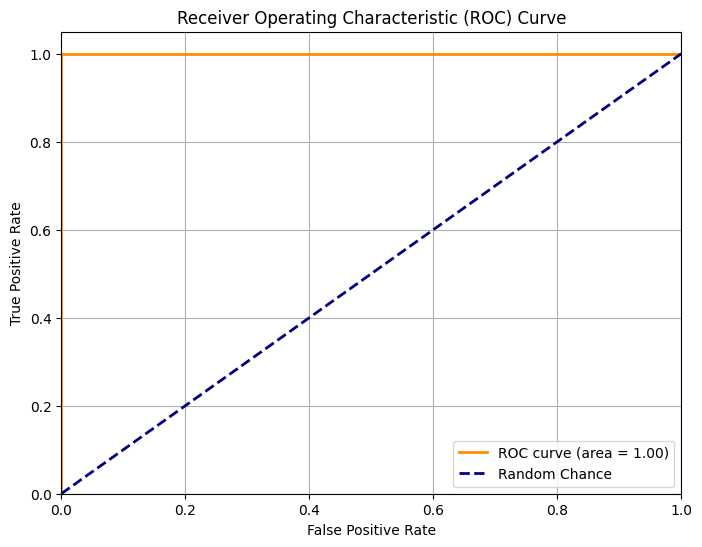

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Preprocessing Data and Train Model 

line_item_totals = df_report['text'].apply(lambda x: sum(float(total) for total in re.findall(r"=\s*\$([\d.]+)", x)))
df_report['calculated_total'] = round(line_item_totals, 2)
df_report['pred_total'] = df_report['pred_total'].astype(float)
df_report['total_mismatch'] = (df_report['pred_total'] != df_report['calculated_total']).astype(int)
df_report['is_duplicate'] = df_report['pred_invoice_no'].duplicated(keep=False).astype(int)
amount_threshold = df_report['pred_total'].quantile(0.95)
df_report['is_high_amount'] = (df_report['pred_total'] > amount_threshold).astype(int)

features = ['total_mismatch', 'is_duplicate', 'is_high_amount', 'pred_total']
target = 'is_anomaly'

X = df_report[features]
y = df_report[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced').fit(X_train, y_train)

# Generate Predictions and Probabilities 
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the 'anomaly' class

# Calculate and Display Metrics 
print("\n--- Anomaly Detection Evaluation Report ---")
# F1-Score is included in this report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# AUC-ROC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_score:.4f}")
print("------------------------------------------")


# 4. Plot the ROC Curve 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##  bonus : feedback loop for human correction of extraction errors to improve model performance.

In [22]:
import pandas as pd
import random


data = [
    {"invoice_id":"INV-1001", "vendor":"Beeta Ltd", "date":"2025-01-15", "amount":500.0},
    {"invoice_id":"INV-1002", "vendor":"Alpha Corp", "date":"2025-02-20", "amount":1200.0},
    {"invoice_id":"INV-1003", "vendor":"Gama Inc",  "date":"2025-03-10", "amount":750.0},
]
df_extracted = pd.DataFrame(data)

df_extracted["corrected_vendor"] = df_extracted["vendor"]
df_extracted.loc[0, "corrected_vendor"] = "Beta Ltd"   # human corrected
df_extracted.loc[2, "corrected_vendor"] = "Gamma Inc"  # human corrected


df_extracted.to_csv("invoice_feedback.csv", index=False)
print("Feedback corrections saved -> invoice_feedback.csv")
print(df_extracted)



training_data = df_extracted[["invoice_id","corrected_vendor","date","amount"]]
print("\nTraining data with human corrections:\n")
print(training_data)

Feedback corrections saved -> invoice_feedback.csv
  invoice_id      vendor        date  amount corrected_vendor
0   INV-1001   Beeta Ltd  2025-01-15   500.0         Beta Ltd
1   INV-1002  Alpha Corp  2025-02-20  1200.0       Alpha Corp
2   INV-1003    Gama Inc  2025-03-10   750.0        Gamma Inc

Training data with human corrections:

  invoice_id corrected_vendor        date  amount
0   INV-1001         Beta Ltd  2025-01-15   500.0
1   INV-1002       Alpha Corp  2025-02-20  1200.0
2   INV-1003        Gamma Inc  2025-03-10   750.0


## bonus: Explore few-shot or zero-shot learning for adapting to new invoice formats.

In [23]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
text_snippet = " "
labels = ["vendor", "date", "amount", "invoice_id"]
result = classifier(text_snippet, labels)

print(result)

Device set to use cpu


{'sequence': ' ', 'labels': ['amount', 'vendor', 'date', 'invoice_id'], 'scores': [0.3616369664669037, 0.2568787932395935, 0.2504223883152008, 0.13106180727481842]}


## Evaluation metrics report (e.g., Precision, Recall, F1 for extraction; AUC-ROC, F1-score for anomaly detection).


📑 Extraction Metrics Report

Field: Vendor
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Field: Invoice
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Field: Total
  Precision: 1.0000
  Recall: 0.9000
  F1-score: 0.9474

📊 Anomaly Detection Metrics Report
Precision    : 1.0000
Recall       : 1.0000
F1-score     : 1.0000
AUC-ROC      : 1.0000


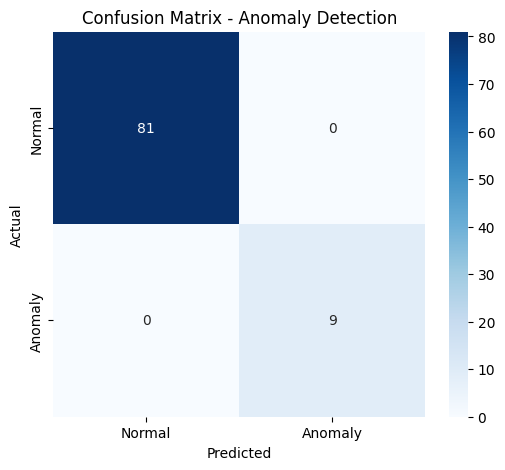

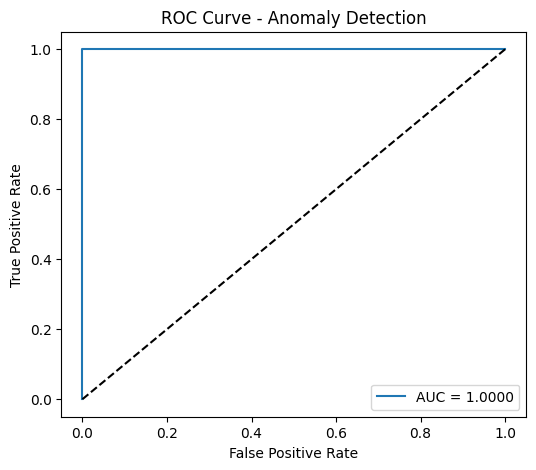

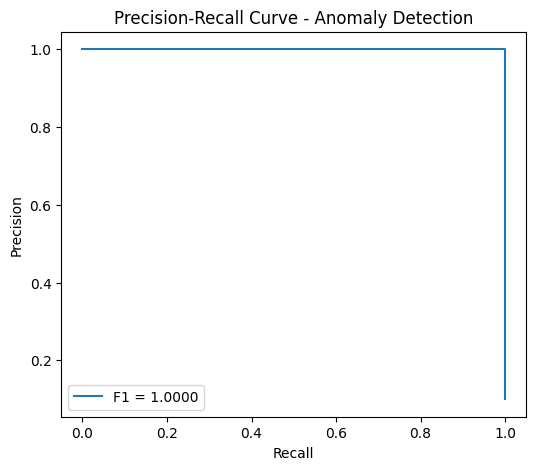

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve


#  Extraction Evaluation 


# Vendor match (string comparison, case-insensitive)
df_final["vendor_match"] = df_final.apply(
    lambda row: str(row["vendor"]).strip().lower() in row["text"].lower(), axis=1
)

# Invoice number match
df_final["invoice_match"] = df_final.apply(
    lambda row: str(row["invoice_no"]) in row["text"], axis=1
)

# Total amount match (calculated vs extracted displayed)
df_final["total_match"] = df_final["calculated_total"].round(2) == df_final["displayed_total"].round(2)

# Compute precision/recall/F1 for extraction (treat match=1 as correct, 0 as incorrect)
extraction_metrics = {}
for field in ["vendor_match", "invoice_match", "total_match"]:
    y_true = [1] * len(df_final)   # ground truth is always 1 (since text contains correct info)
    y_pred = df_final[field].astype(int)
    extraction_metrics[field] = {
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

print("\n📑 Extraction Metrics Report")
for field, scores in extraction_metrics.items():
    print(f"\nField: {field.replace('_match','').capitalize()}")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")

# Anomaly Detection Evaluation


# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n📊 Anomaly Detection Metrics Report")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1-score     : {f1:.4f}")
print(f"AUC-ROC      : {auc:.4f}")


#  Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix - Anomaly Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve - Anomaly Detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


#  Precision-Recall Curve

prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label=f"F1 = {f1:.4f}")
plt.title("Precision-Recall Curve - Anomaly Detection")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
